In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [2]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0
!pip install segmentation-models

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pickle

Using TensorFlow backend.


In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['container', 'oil tanker', 'aircraft carrier', 'maritime vessels']
    
    def __init__(
            self, 
            base_dir,
            pickle_file,            
            #classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.base_dir = base_dir
        #file = "/content/gdrive/My Drive/findShip/polygon_train.pickle" 
        pickle_path = os.path.join(base_dir, pickle_file)
        with open(pickle_path, 'rb') as f:
            self.annots = pickle.load(f) 

        print("## All Data :", len(self.annots))
        
        self.classes = {'container': 1, 'oil tanker': 2, 'aircraft carrier': 3, 'maritime vessels': 4}
        # convert str names to class values on masks
        self.class_values = list(self.classes.values())#[self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, index):
        
        # read data
        filepath = os.path.join(self.base_dir, 'patch_images', self.annots[index]['image_filename'])
        
        #print()
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        width, height = image.shape[:2]
        img = Image.new('L', (width, height), 0)

        for annot in self.annots[index]['bboxes']:
            label, polygon = annot['label'], annot['bbox']
            ImageDraw.Draw(img).polygon(polygon, fill=int(label))
            
        mask = np.array(img)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.annots)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [0]:
image, mask = dataset[2]

In [0]:
mask.shape[-1] != 1

True

In [0]:
mask[...,0].shape

(360, 480)

## All Data : 7603


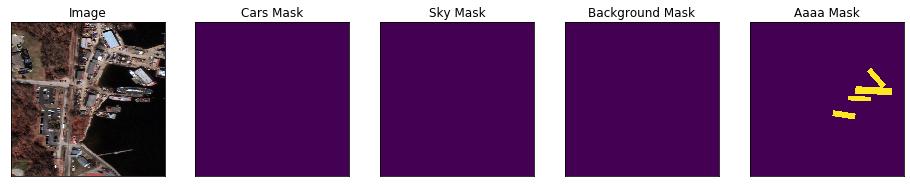

In [0]:
# Lets look at data we have
dataset = Dataset('/content/gdrive/My Drive/findShip', 'polygon_train.pickle' )

image, mask = dataset[2] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
    aaaa_mask=mask[..., 3].squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [0]:
import albumentations as A

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


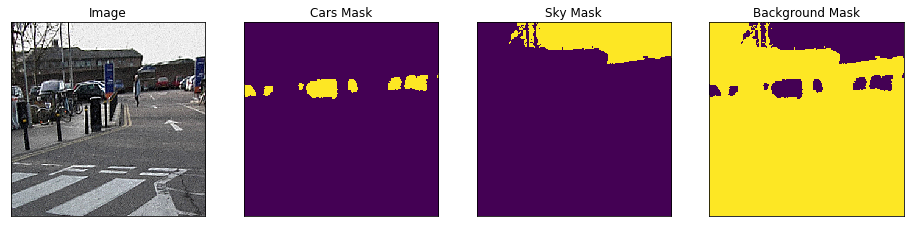

In [0]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'sky'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

# Segmentation model training

In [7]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'efficientnetb4'
BATCH_SIZE = 1
CLASSES = ['container', 'oil tanker', 'aircraft carrier', 'maritime vessels']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [9]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
#n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation

activation = 'sigmoid' if n_classes == 1 else 'softmax'


#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
71892992/71892840 [==============================] - 2s 0us/step




In [10]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1, 1, 1, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [0]:
model.load_weights("/content/gdrive/My Drive/findShip/models/best_model.h5") 

In [0]:
n_classes

5

In [12]:
# Dataset for train images
train_dataset = Dataset('/content/gdrive/My Drive/findShip', 'polygon_train.pickle' )
"""
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
"""

# Dataset for validation images
valid_dataset = Dataset('/content/gdrive/My Drive/findShip', 'polygon_test.pickle' )
"""
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
"""

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 1024, 1024, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 1024, 1024, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/findShip/models/bbbest_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

## All Data : 7603
## All Data : 1945


KeyboardInterrupt: ignored

In [0]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    workers=100,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [14]:
"""
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
"""
test_dataset = Dataset('/content/gdrive/My Drive/findShip', 'polygon_test.pickle' )
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

## All Data : 1945


In [0]:
# load best weights
model.load_weights("/content/gdrive/My Drive/findShip/models/best_model.h5") 

In [0]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# Visualization of results on test dataset

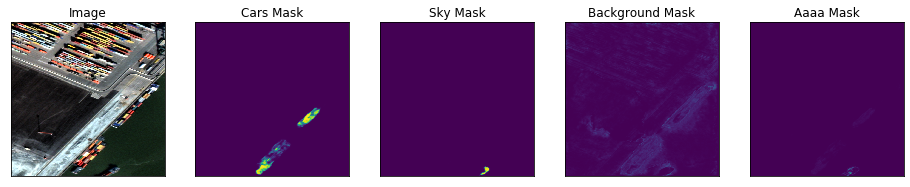

In [18]:
i = 21
image, gt_mask = test_dataset[i]
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image)

visualize(
    image=denormalize(image.squeeze()),
    cars_mask=pr_mask[..., 0].squeeze(),
    sky_mask=pr_mask[..., 1].squeeze(),
    background_mask=pr_mask[..., 2].squeeze(),
    aaaa_mask=pr_mask[..., 3].squeeze(),
)

In [0]:
pr_mask = pr_mask.squeeze()

In [21]:
pr_mask[..., 1].shape

(1024, 1024)

In [96]:
cv2.merge((pr_mask[..., 3],pr_mask[..., 3],pr_mask[..., 3])).shape

(1024, 1024, 3)

In [76]:
mask = np.argmax(pr_mask[..., :4], axis = 2) 
mask.shape

(1024, 1024)

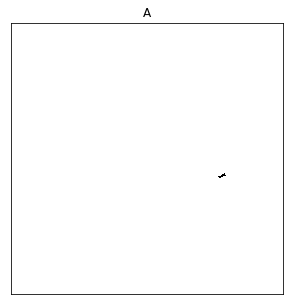

In [104]:
visualize(
a = cv2.merge((masked_mask, masked_mask, masked_mask))
)

In [0]:
img_n = cv2.normalize(src=pr_mask[..., 0], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [0]:
ret, threshed_img = cv2.threshold(img_n,
                127, 255, cv2.THRESH_BINARY)

contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)

len(contours)

In [0]:
persent_mask = np.argmax(pr_mask[..., :4], axis = 2) 

In [0]:
persent_mask = cv2.merge((persent_mask,persent_mask,persent_mask))

In [70]:
np.count_nonzero(persent_mask == 0), np.count_nonzero(persent_mask != 2)

(110337, 126897)

In [98]:
np.count_nonzero(persent_mask == 0), np.count_nonzero(persent_mask != 2)

(36779, 42299)

In [0]:
from google.colab.patches import cv2_imshow

In [107]:
img = image.squeeze().copy()
print(img.shape)

persent_mask = np.argmax(pr_mask[..., :4], axis = 2) 

mask = np.ones((1024,1024), dtype=np.int32)
mask.fill(255)


label = {'container': 0, 'oil tanker': 1, 'aircraft carrier': 2, 'maritime vessels': 3}

for c in contours:
    # get the bounding rect
    #x, y, w, h = cv2.boundingRect(c)
    # draw a green rectangle to visualize the bounding rect
    #cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #print(x, y, w, h)
    # get the min area rect
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    # convert all coordinates floating point values to int
    box = np.int0(box)
    # draw a red 'nghien' rectangle
    cv2.drawContours(img, [box], 0, (0, 0, 255))

        #퍼센트 계산
    mk = mask.copy()
    roi_corners = np.array([box], dtype=np.int32)
    # fill the ROI into the mask
    cv2.fillPoly(mk, roi_corners, 0)
    # applying th mask to original image
    masked_mask = cv2.bitwise_or(persent_mask, mk)
    total = np.count_nonzero(masked_mask != 255) # 기본배경이 255이기 때문
    c = np.count_nonzero(masked_mask == label['container']) 
    o = np.count_nonzero(masked_mask == label['oil tanker']) 
    a = np.count_nonzero(masked_mask == label['aircraft carrier']) 
    m = np.count_nonzero(masked_mask == label['maritime vessels']) 
    print(c/total, o/total, a/total, m/total, total)

    # finally, get the min enclosing circle
    #(x, y), radius = cv2.minEnclosingCircle(c)
    # convert all values to int
    #center = (int(x), int(y))
    #radius = int(radius)
    # and draw the circle in blue
    #img = cv2.circle(img, center, radius, (255, 0, 0), 2)

#cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

#cv2_imshow(img)

(1024, 1024, 3)
1.0 0.0 0.0 0.0 1
0.9399424598417646 0.0 0.06005754015823544 0.0 8342
1.0 0.0 0.0 0.0 1
1.0 0.0 0.0 0.0 1
1.0 0.0 0.0 0.0 21
1.0 0.0 0.0 0.0 56
1.0 0.0 0.0 0.0 399
1.0 0.0 0.0 0.0 4
1.0 0.0 0.0 0.0 1
1.0 0.0 0.0 0.0 3
0.9988751406074241 0.0 0.0011248593925759281 0.0 889
0.9948761742100769 0.0 0.005123825789923143 0.0 7026
1.0 0.0 0.0 0.0 31
1.0 0.0 0.0 0.0 225


In [102]:
persent_mask

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [85]:
type(persent_mask), type(mk)

(numpy.ndarray, numpy.ndarray)

In [91]:
persent_mask.dtype

dtype('int64')

In [94]:
c, o, a, m

(0, 0, 0, 0)

In [89]:
cv2.bitwise_or(persent_mask, mk)

error: ignored

In [0]:

# mask defaulting to black for 3-channel and transparent for 4-channel
# (of course replace corners with yours)
mask = np.zeros(img.shape, dtype=np.uint8)
roi_corners = np.array([[(10,10), (300,300), (10,300)]], dtype=np.int32)
# fill the ROI so it doesn't get wiped out when the mask is applied
channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
ignore_mask_color = (255,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)
# from Masterfool: use cv2.fillConvexPoly if you know it's convex

# apply the mask
masked_image = cv2.bitwise_and(img, mask)


In [56]:
np.array([box], dtype=np.int32).shape


(1, 4, 2)

In [0]:
masked_image

In [0]:
 numpy.count_nonzero(pr_mask == 3)

In [59]:
np.count_nonzero(pr_mask)

5242880

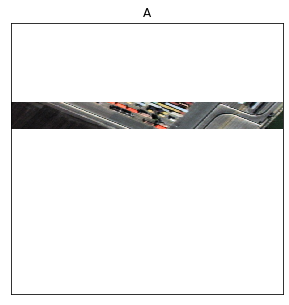

In [51]:
visualize(
a = masked_image
)

In [87]:

np.count_nonzero(mask == 0),np.count_nonzero(mask == 1),np.count_nonzero(mask == 2),np.count_nonzero(mask == 3)

(94392, 40953, 913231, 0)

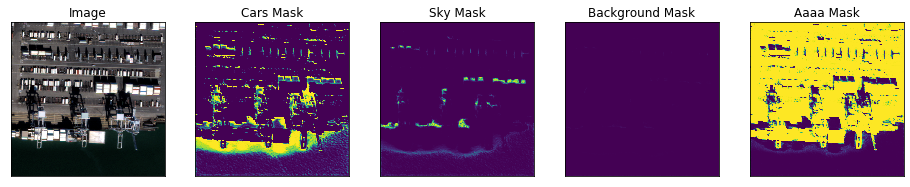

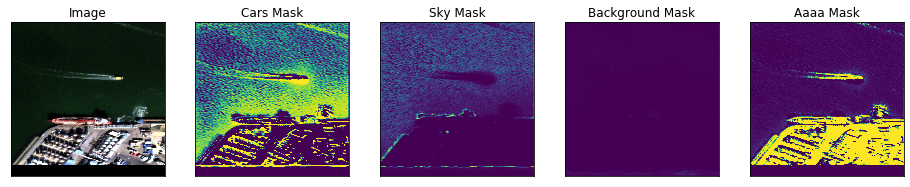

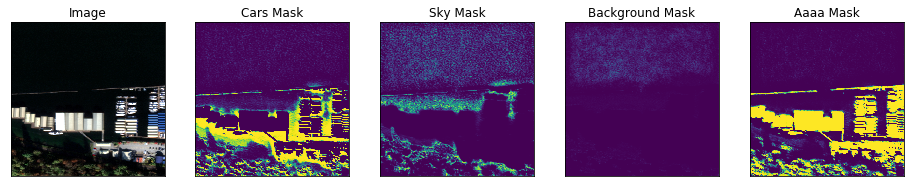

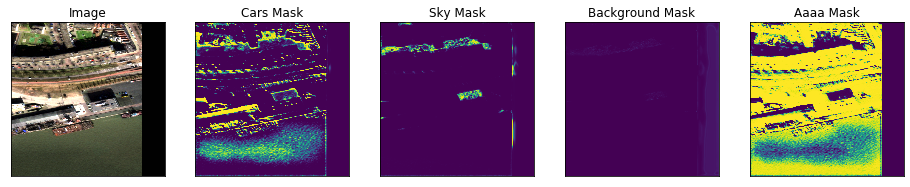

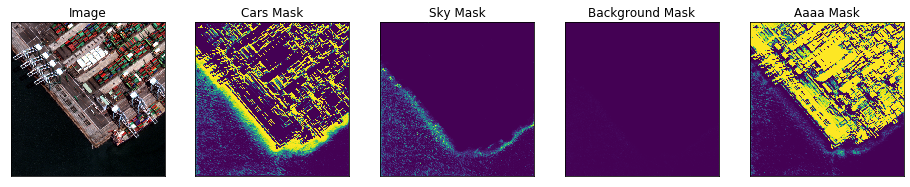

In [17]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        cars_mask=pr_mask[..., 0].squeeze(),
        sky_mask=pr_mask[..., 1].squeeze(),
        background_mask=pr_mask[..., 2].squeeze(),
        aaaa_mask=pr_mask[..., 3].squeeze(),
    )